# Project 1

# Used Vehicle Price Prediction

## Introduction

- 1.2 Million listings scraped from TrueCar.com - Price, Mileage, Make, Model dataset from Kaggle: [data](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Each observation represents the price of an used car

In [387]:
%matplotlib inline
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [388]:
data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')

In [389]:
data.head(10)

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,MD,Nissan,MuranoAWD
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe
2,20925,2016,24633,SC,Hyundai,Santa
3,14500,2012,84026,OK,Jeep,Grand
4,32488,2013,22816,TN,Jeep,Wrangler
5,37944,2017,5362,FL,Jeep,Wrangler
6,18995,2010,69431,NH,Ford,F-1504WD
7,28000,2015,35090,WI,Ford,ExplorerXLT
8,10995,2012,35100,NY,Hyundai,Sonata4dr
9,32991,2017,14238,TX,Kia,SorentoSX


In [390]:
data.shape

(500000, 6)

In [391]:
data.Price.describe()

count    500000.000000
mean      21144.186304
std       10753.259704
min        5001.000000
25%       13499.000000
50%       18450.000000
75%       26998.000000
max       79999.000000
Name: Price, dtype: float64

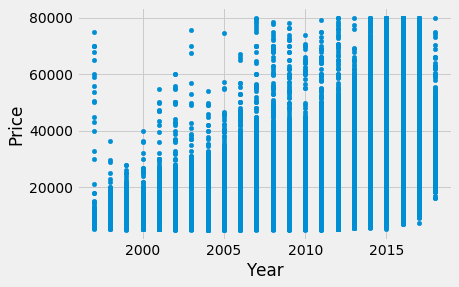

In [392]:
data.plot(kind='scatter', y='Price', x='Year')

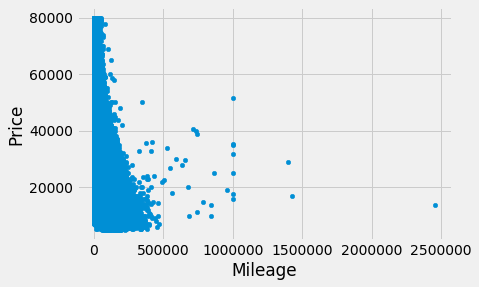

In [393]:
data.plot(kind='scatter', y='Price', x='Mileage')

In [394]:
data.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

# Exercise P1.1 (50%)

Develop a machine learning model that predicts the price of the of car using as an input ['Year', 'Mileage', 'State', 'Make', 'Model']

Submit the prediction of the testing set to Kaggle
https://www.kaggle.com/c/miia4200-20191-p1-usedcarpriceprediction

#### Evaluation:
- 25% - Performance of the model in the Kaggle Private Leaderboard
- 25% - Notebook explaining the modeling process


In [395]:
#data_test = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTest_carListings.zip', index_col=0)

In [396]:
#data_test.head()

In [397]:
#data_test.shape

### Analisis de la Data

In [398]:
data.dtypes

Price       int64
Year        int64
Mileage     int64
State      object
Make       object
Model      object
dtype: object

In [399]:
#sns.distplot(data["Price"]);

In [400]:
#sns.pairplot(data);

In [401]:
data.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

In [402]:
data1=data[(data["Model"]=="Wrangler") & (data["Year"]<=2017)]

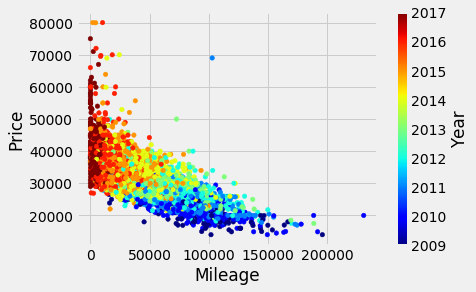

In [403]:
data1.plot(kind='scatter', y='Price', x='Mileage',c="Year",colormap='jet')

### Identificacion de Atipicos

### Preparacion de la Data

In [404]:
import category_encoders as ce

#### Creacion de variables

In [405]:
data['Year_s']=data[str('Year')]

In [406]:
data['Mileage_c'] = 'Na'
data.loc[(data['Mileage'] > 0)      & (data['Mileage'] <= 20000 ), 'Mileage_c'] = 'R1'
data.loc[(data['Mileage'] > 20000)  & (data['Mileage'] <= 40000 ), 'Mileage_c'] = 'R2'
data.loc[(data['Mileage'] > 40000)  & (data['Mileage'] <= 60000 ), 'Mileage_c'] = 'R3'
data.loc[(data['Mileage'] > 60000)  & (data['Mileage'] <= 80000 ), 'Mileage_c'] = 'R4'
data.loc[(data['Mileage'] > 80000)  & (data['Mileage'] <= 100000), 'Mileage_c'] = 'R5'
data.loc[(data['Mileage'] > 100000) & (data['Mileage'] <= 120000), 'Mileage_c'] = 'R6'
data.loc[(data['Mileage'] > 120000) & (data['Mileage'] <= 140000), 'Mileage_c'] = 'R7'
data.loc[(data['Mileage'] > 120000), 'Mileage_c'] = 'R8'

In [407]:
data['Anio_max']=2019
data['Antiguedad']=data['Anio_max'].subtract(data['Year'], axis='index')
data.head(10)

,Price,Year,Mileage,State,Make,Model,Year_s,Mileage_c,Anio_max,Antiguedad
0,21490,2014,31909,MD,Nissan,MuranoAWD,2014,R2,2019,5
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe,2016,R2,2019,3
2,20925,2016,24633,SC,Hyundai,Santa,2016,R2,2019,3
3,14500,2012,84026,OK,Jeep,Grand,2012,R5,2019,7
4,32488,2013,22816,TN,Jeep,Wrangler,2013,R2,2019,6
5,37944,2017,5362,FL,Jeep,Wrangler,2017,R1,2019,2
6,18995,2010,69431,NH,Ford,F-1504WD,2010,R4,2019,9
7,28000,2015,35090,WI,Ford,ExplorerXLT,2015,R2,2019,4
8,10995,2012,35100,NY,Hyundai,Sonata4dr,2012,R2,2019,7
9,32991,2017,14238,TX,Kia,SorentoSX,2017,R1,2019,2


In [408]:
data['A'] = 'Na'
data.loc[(data['Antiguedad'] > 0)  & (data['Antiguedad'] <= 3 ), 'A'] = 'A1'
data.loc[(data['Antiguedad'] > 3)  & (data['Antiguedad'] <= 5 ), 'A'] = 'A2'
data.loc[(data['Antiguedad'] > 5)  & (data['Antiguedad'] <= 10), 'A'] = 'A3'
data.loc[(data['Antiguedad'] > 10) & (data['Antiguedad'] <= 15), 'A'] = 'A4'
data.loc[(data['Antiguedad'] > 15) & (data['Antiguedad'] <= 20), 'A'] = 'A5'
data.loc[(data['Antiguedad'] > 20), 'A'] = 'A6'

data.head(10)

,Price,Year,Mileage,State,Make,Model,Year_s,Mileage_c,Anio_max,Antiguedad,A
0,21490,2014,31909,MD,Nissan,MuranoAWD,2014,R2,2019,5,A2
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe,2016,R2,2019,3,A1
2,20925,2016,24633,SC,Hyundai,Santa,2016,R2,2019,3,A1
3,14500,2012,84026,OK,Jeep,Grand,2012,R5,2019,7,A3
4,32488,2013,22816,TN,Jeep,Wrangler,2013,R2,2019,6,A3
5,37944,2017,5362,FL,Jeep,Wrangler,2017,R1,2019,2,A1
6,18995,2010,69431,NH,Ford,F-1504WD,2010,R4,2019,9,A3
7,28000,2015,35090,WI,Ford,ExplorerXLT,2015,R2,2019,4,A2
8,10995,2012,35100,NY,Hyundai,Sonata4dr,2012,R2,2019,7,A3
9,32991,2017,14238,TX,Kia,SorentoSX,2017,R1,2019,2,A1


In [409]:
data['MR']=data['A']+data['Mileage_c']
MR_1=pd.get_dummies(data['MR'], prefix='MR')
MR_1.head()

,MR_A1R1,MR_A1R2,MR_A1R3,MR_A1R4,MR_A1R5,MR_A1R6,MR_A1R8,MR_A2R1,MR_A2R2,MR_A2R3,...,MR_A5R5,MR_A5R6,MR_A5R8,MR_A6R1,MR_A6R2,MR_A6R3,MR_A6R4,MR_A6R5,MR_A6R6,MR_A6R8
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [410]:
X_1=pd.get_dummies(data['Year_s'], prefix='Y')

In [411]:
X_1.head(5)

,Y_1997,Y_1998,Y_1999,Y_2000,Y_2001,Y_2002,Y_2003,Y_2004,Y_2005,Y_2006,...,Y_2009,Y_2010,Y_2011,Y_2012,Y_2013,Y_2014,Y_2015,Y_2016,Y_2017,Y_2018
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [412]:
data2=pd.DataFrame(data['State'])

In [413]:
data2.describe()

,State
count,500000
unique,51
top,TX
freq,57153


In [414]:
data2.head()

,State
0,MD
1,KY
2,SC
3,OK
4,TN


In [415]:
X_2 = ce.BinaryEncoder().fit_transform(data2)

In [416]:
X_2.head(5)

,State_0,State_1,State_2,State_3,State_4,State_5,State_6
0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0
2,0,0,0,0,0,1,1
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,1


In [417]:
data3=pd.DataFrame(data['Make'])

In [418]:
data3.describe()

,Make
count,500000
unique,38
top,Ford
freq,78627


In [419]:
X_3 = ce.BinaryEncoder().fit_transform(data3)

In [420]:
X_3.head(5)

,Make_0,Make_1,Make_2,Make_3,Make_4,Make_5,Make_6
0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0
2,0,0,0,0,0,1,1
3,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0


In [421]:
data4=pd.DataFrame(data['Model'])
X_4 = ce.BinaryEncoder().fit_transform(data4)
X_4.head()

,Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10
0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,1,0,1


In [422]:
X =pd.concat([data['Mileage'],MR_1,X_1,X_2,X_3,X_4],axis=1)

In [423]:
X.head(5)

,Mileage,MR_A1R1,MR_A1R2,MR_A1R3,MR_A1R4,MR_A1R5,MR_A1R6,MR_A1R8,MR_A2R1,MR_A2R2,...,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10
0,31909,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,25741,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,24633,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,84026,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,22816,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [424]:
Price_model_mean=data.groupby(['Year','Model','Mileage_c'])['Price'].mean()
Price_model_mean=pd.DataFrame(Price_model_mean)
Price_model_mean.head(10)

Price
Year Model          Mileage_c              
1997 3              R3         32995.000000
                    R4          7849.500000
                    R5          6900.000000
                    R8          8277.000000
     4Runner4dr     R8          7180.333333
     4RunnerLimited R8          5888.000000
     4RunnerSR5     R8          9997.000000
     911            R2         65425.000000
                    R3         52195.000000
                    R4         69900.000000

In [425]:
Price_model_Q3=data.groupby(['Year','Model','Mileage_c'])['Price'].quantile(0.975)
Price_model_Q3=pd.DataFrame(Price_model_Q3)
Price_model_Q3=Price_model_Q3.rename(columns={'Price':'Price_Q3'})
Price_model_Q3.head(10)

Price_Q3
Year Model          Mileage_c           
1997 3              R3         32995.000
                    R4          8847.475
                    R5          6900.000
                    R8          8962.900
     4Runner4dr     R8          9749.000
     4RunnerLimited R8          5888.000
     4RunnerSR5     R8         12845.100
     911            R2         74473.750
                    R3         53719.750
                    R4         69900.000

In [426]:
data=pd.merge(data,Price_model_Q3,on=['Year','Model','Mileage_c'], how='left')
data.head(5)

,Price,Year,Mileage,State,Make,Model,Year_s,Mileage_c,Anio_max,Antiguedad,A,MR,Price_Q3
0,21490,2014,31909,MD,Nissan,MuranoAWD,2014,R2,2019,5,A2,A2R2,26524.550
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe,2016,R2,2019,3,A1,A1R2,34707.150
2,20925,2016,24633,SC,Hyundai,Santa,2016,R2,2019,3,A1,A1R2,29680.500
3,14500,2012,84026,OK,Jeep,Grand,2012,R5,2019,7,A3,A3R5,22992.950
4,32488,2013,22816,TN,Jeep,Wrangler,2013,R2,2019,6,A3,A3R2,38214.975


In [427]:
prueba=data.loc[(data['Price'] > data['Price_Q3'])]
prueba.head(5)

,Price,Year,Mileage,State,Make,Model,Year_s,Mileage_c,Anio_max,Antiguedad,A,MR,Price_Q3
12,64997,2015,19790,AL,Ford,Super,2015,R1,2019,4,A2,A2R1,62533.025
56,9694,2007,128387,WA,Ford,Ranger2WD,2007,R8,2019,12,A4,A4R8,9664.900
68,43595,2015,67037,SD,Ford,F-150Lariat,2015,R4,2019,4,A2,A2R4,41438.000
72,18995,2007,101359,CA,Audi,Q7quattro,2007,R6,2019,12,A4,A4R6,17181.500
74,21515,2014,37184,WA,Honda,CR-VEX,2014,R2,2019,5,A2,A2R2,20998.000


In [428]:
prueba.shape

(24190, 13)

In [429]:
prueba2=data.loc[(data['Year']==2015) & (data['Model']=='Super') & (data['Mileage_c']=='R1')]
prueba2.head(10)

,Price,Year,Mileage,State,Make,Model,Year_s,Mileage_c,Anio_max,Antiguedad,A,MR,Price_Q3
12,64997,2015,19790,AL,Ford,Super,2015,R1,2019,4,A2,A2R1,62533.025
223,55000,2015,19661,NC,Ford,Super,2015,R1,2019,4,A2,A2R1,62533.025
21277,56995,2015,19243,CA,Ford,Super,2015,R1,2019,4,A2,A2R1,62533.025
23744,59995,2015,2148,CA,Ford,Super,2015,R1,2019,4,A2,A2R1,62533.025
26651,44800,2015,19778,WA,Ford,Super,2015,R1,2019,4,A2,A2R1,62533.025
27638,39995,2015,17845,PA,Ford,Super,2015,R1,2019,4,A2,A2R1,62533.025
30091,49750,2015,16903,AZ,Ford,Super,2015,R1,2019,4,A2,A2R1,62533.025
30382,54448,2015,19061,TN,Ford,Super,2015,R1,2019,4,A2,A2R1,62533.025
43276,52777,2015,13039,AZ,Ford,Super,2015,R1,2019,4,A2,A2R1,62533.025
50755,48474,2015,12253,NE,Ford,Super,2015,R1,2019,4,A2,A2R1,62533.025


In [430]:
data['Price_origin']=data['Price']
data.loc[(data['Price'] > data['Price_Q3']), 'Price'] = data['Price_Q3']
data.head(5)

,Price,Year,Mileage,State,Make,Model,Year_s,Mileage_c,Anio_max,Antiguedad,A,MR,Price_Q3,Price_origin
0,21490.0,2014,31909,MD,Nissan,MuranoAWD,2014,R2,2019,5,A2,A2R2,26524.550,21490
1,21250.0,2016,25741,KY,Chevrolet,CamaroCoupe,2016,R2,2019,3,A1,A1R2,34707.150,21250
2,20925.0,2016,24633,SC,Hyundai,Santa,2016,R2,2019,3,A1,A1R2,29680.500,20925
3,14500.0,2012,84026,OK,Jeep,Grand,2012,R5,2019,7,A3,A3R5,22992.950,14500
4,32488.0,2013,22816,TN,Jeep,Wrangler,2013,R2,2019,6,A3,A3R2,38214.975,32488


In [431]:
prueba3=data.loc[(data['Price'] > data['Price_Q3'])]
prueba3.head(5)

,Price,Year,Mileage,State,Make,Model,Year_s,Mileage_c,Anio_max,Antiguedad,A,MR,Price_Q3,Price_origin


In [432]:
y = data['Price']

### Division del archivo en train y test para la preparacion del modelo

In [433]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [434]:
y_test.head(5)

104241    18231.000
199676    22982.000
140199    16219.000
132814    21683.125
408697    17995.000
Name: Price, dtype: float64

In [435]:
data['ind']=data.index
data.head(5)

,Price,Year,Mileage,State,Make,Model,Year_s,Mileage_c,Anio_max,Antiguedad,A,MR,Price_Q3,Price_origin,ind
0,21490.0,2014,31909,MD,Nissan,MuranoAWD,2014,R2,2019,5,A2,A2R2,26524.550,21490,0
1,21250.0,2016,25741,KY,Chevrolet,CamaroCoupe,2016,R2,2019,3,A1,A1R2,34707.150,21250,1
2,20925.0,2016,24633,SC,Hyundai,Santa,2016,R2,2019,3,A1,A1R2,29680.500,20925,2
3,14500.0,2012,84026,OK,Jeep,Grand,2012,R5,2019,7,A3,A3R5,22992.950,14500,3
4,32488.0,2013,22816,TN,Jeep,Wrangler,2013,R2,2019,6,A3,A3R2,38214.975,32488,4


In [436]:
y_test=pd.DataFrame(y_test)
y_test['ind']=y_test.index
y_test.shape

(250000, 2)

In [437]:
y_test=pd.DataFrame(y_test)
y_test.head(5)

,Price,ind
104241,18231.000,104241
199676,22982.000,199676
140199,16219.000,140199
132814,21683.125,132814
408697,17995.000,408697


In [438]:
data.head(5)

,Price,Year,Mileage,State,Make,Model,Year_s,Mileage_c,Anio_max,Antiguedad,A,MR,Price_Q3,Price_origin,ind
0,21490.0,2014,31909,MD,Nissan,MuranoAWD,2014,R2,2019,5,A2,A2R2,26524.550,21490,0
1,21250.0,2016,25741,KY,Chevrolet,CamaroCoupe,2016,R2,2019,3,A1,A1R2,34707.150,21250,1
2,20925.0,2016,24633,SC,Hyundai,Santa,2016,R2,2019,3,A1,A1R2,29680.500,20925,2
3,14500.0,2012,84026,OK,Jeep,Grand,2012,R5,2019,7,A3,A3R5,22992.950,14500,3
4,32488.0,2013,22816,TN,Jeep,Wrangler,2013,R2,2019,6,A3,A3R2,38214.975,32488,4


In [439]:
data.shape

(500000, 15)

In [440]:
y_test1=pd.merge(y_test,data, on='ind', how='left')
y_test1.head(5)

,Price_x,ind,Price_y,Year,Mileage,State,Make,Model,Year_s,Mileage_c,Anio_max,Antiguedad,A,MR,Price_Q3,Price_origin
0,18231.000,104241,18231.000,2017,30223,CA,Kia,SportageAWD,2017,R2,2019,2,A1,A1R2,21999.000,18231
1,22982.000,199676,22982.000,2015,12764,AZ,Chevrolet,EquinoxFWD,2015,R1,2019,4,A2,A2R1,23995.250,22982
2,16219.000,140199,16219.000,2017,37951,MD,Ford,FusionSE,2017,R2,2019,2,A1,A1R2,19998.050,16219
3,21683.125,132814,21683.125,2016,80649,SD,Subaru,Outback2.5i,2016,R5,2019,3,A1,A1R5,21683.125,21995
4,17995.000,408697,17995.000,2014,24579,NY,Volkswagen,Jetta,2014,R2,2019,5,A2,A2R2,18385.800,17995


In [441]:
y_test1.shape

(250000, 16)

In [442]:
y_test=y_test1['Price_origin']
y_test = y_test.rename(columns={'Price': 'Price_origin'})
y_test.head(5)

0    18231
1    22982
2    16219
3    21995
4    17995
dtype: int64

In [443]:
X_train.shape

(250000, 90)

In [444]:
X_train.head(10)

,Mileage,MR_A1R1,MR_A1R2,MR_A1R3,MR_A1R4,MR_A1R5,MR_A1R6,MR_A1R8,MR_A2R1,MR_A2R2,...,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10
315366,18423,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,1,0
196832,16162,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,1,1,0
187640,70974,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,1,1,1,0,1
418842,82327,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
72547,32588,0,0,0,0,0,0,0,0,1,...,0,0,1,1,1,1,0,1,0,1
277072,39210,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1
179187,30075,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,1,1,0,0,1
453628,89355,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
249295,22646,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,1,0
474351,33137,0,1,0,0,0,0,0,0,0,...,0,0,1,1,0,1,0,0,0,1


In [445]:
y_train.head(10)

315366    29970.0
196832    32999.0
187640    13995.0
418842    10499.0
72547     15999.0
277072    17280.0
179187    41274.0
453628    22995.0
249295    17600.0
474351    22500.0
Name: Price, dtype: float64

In [446]:
data['ind']=data.index
data.head(5)

,Price,Year,Mileage,State,Make,Model,Year_s,Mileage_c,Anio_max,Antiguedad,A,MR,Price_Q3,Price_origin,ind
0,21490.0,2014,31909,MD,Nissan,MuranoAWD,2014,R2,2019,5,A2,A2R2,26524.550,21490,0
1,21250.0,2016,25741,KY,Chevrolet,CamaroCoupe,2016,R2,2019,3,A1,A1R2,34707.150,21250,1
2,20925.0,2016,24633,SC,Hyundai,Santa,2016,R2,2019,3,A1,A1R2,29680.500,20925,2
3,14500.0,2012,84026,OK,Jeep,Grand,2012,R5,2019,7,A3,A3R5,22992.950,14500,3
4,32488.0,2013,22816,TN,Jeep,Wrangler,2013,R2,2019,6,A3,A3R2,38214.975,32488,4


### Identificacion de que muestra del data train usaremos para el modelo (train interno) y para el test interno 

In [447]:
Selec_train=pd.DataFrame(X_train.index)
Selec_train['ind']=Selec_train.iloc[:,0]
Selec_train['Select']="train"
Selec_train=Selec_train[['ind','Select']]
Selec_train.head(5)

,ind,Select
0,315366,train
1,196832,train
2,187640,train
3,418842,train
4,72547,train


In [448]:
Selec_test=pd.DataFrame(X_test.index)
Selec_test['ind']=Selec_test.iloc[:,0]
Selec_test['Select']="test"
Selec_test=Selec_test[['ind','Select']]
Selec_test.head(5)

,ind,Select
0,104241,test
1,199676,test
2,140199,test
3,132814,test
4,408697,test


In [449]:
Selec = Selec_train.append(pd.DataFrame(data = Selec_test), ignore_index=True)
Selec.tail(5)

,ind,Select
499995,466228,test
499996,197602,test
499997,15038,test
499998,376026,test
499999,155686,test


In [450]:
data=pd.merge(data,Selec,on='ind',how='left')
data.head(5)

,Price,Year,Mileage,State,Make,Model,Year_s,Mileage_c,Anio_max,Antiguedad,A,MR,Price_Q3,Price_origin,ind,Select
0,21490.0,2014,31909,MD,Nissan,MuranoAWD,2014,R2,2019,5,A2,A2R2,26524.550,21490,0,test
1,21250.0,2016,25741,KY,Chevrolet,CamaroCoupe,2016,R2,2019,3,A1,A1R2,34707.150,21250,1,train
2,20925.0,2016,24633,SC,Hyundai,Santa,2016,R2,2019,3,A1,A1R2,29680.500,20925,2,test
3,14500.0,2012,84026,OK,Jeep,Grand,2012,R5,2019,7,A3,A3R5,22992.950,14500,3,train
4,32488.0,2013,22816,TN,Jeep,Wrangler,2013,R2,2019,6,A3,A3R2,38214.975,32488,4,train


In [451]:
data.shape

(500000, 16)

## Modelaje

### Modelo 1 - Decision Tree Regressor

In [47]:

clf = DecisionTreeRegressor(max_depth=20, random_state=1)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

# use leave-one-out cross-validation (LOOCV) to estimate the RMSE for this model

scores = cross_val_score(clf, X_test, y_test, cv=14, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

4530.799898844249

In [48]:
y_train.shape

(250000,)

In [49]:
# fit and predict
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred=pd.DataFrame(y_pred)
y_pred.head(5)

,0
0,17980.551724
1,19222.071429
2,14591.142857
3,17812.000000
4,13045.891775


### Analisis de prediccion de precios

In [50]:
y_pred_selec=pd.merge(y_pred,Selec_test,left_index=True, right_index=True)
y_pred_selec['Price_pred']=y_pred_selec.iloc[:,0]
y_pred_selec=y_pred_selec[['ind','Select','Price_pred']]
y_pred_selec.head(5)

,ind,Select,Price_pred
0,104241,test,17980.551724
1,199676,test,19222.071429
2,140199,test,14591.142857
3,132814,test,17812.000000
4,408697,test,13045.891775


In [51]:
y_train.head()

315366    29970
196832    32999
187640    13995
418842    10499
72547     15999
Name: Price, dtype: int64

In [52]:
pd_y_train=pd.DataFrame(y_train)
pd_y_train['Price_pred']=pd_y_train['Price']
pd_y_train = pd_y_train.reset_index(drop=True)
pd_y_train.head()

,Price,Price_pred
0,29970,29970
1,32999,32999
2,13995,13995
3,10499,10499
4,15999,15999


In [53]:
y_train_ind=pd.DataFrame(y_train.index)
y_train_ind.head()

,0
0,315366
1,196832
2,187640
3,418842
4,72547


In [54]:
y_price=pd.concat([y_train_ind,pd_y_train],axis=1)
y_price['ind']=y_price.iloc[:,0]
y_price=y_price[['ind','Price_pred']]
y_price.head(5)

,ind,Price_pred
0,315366,29970
1,196832,32999
2,187640,13995
3,418842,10499
4,72547,15999


In [55]:
y_price.shape

(250000, 2)

In [56]:
Price = y_pred_selec.append(pd.DataFrame(data = y_price), ignore_index=True, sort='ind')
Price=Price[['ind','Price_pred']]
Price.tail(5)

,ind,Price_pred
499995,259178,11994.0
499996,365838,17900.0
499997,131932,11500.0
499998,146867,19900.0
499999,121958,19000.0


In [57]:
data=pd.merge(data,Price,on='ind',how='left')
#data['Dif']=data[data['Price']-data['Price_pred']]

In [58]:
data.head(10)

,Price,Year,Mileage,State,Make,Model,Year_s,ind,Select,Price_pred
0,21490,2014,31909,MD,Nissan,MuranoAWD,2014,0,test,21033.022222
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe,2016,1,train,21250.000000
2,20925,2016,24633,SC,Hyundai,Santa,2016,2,test,24151.625000
3,14500,2012,84026,OK,Jeep,Grand,2012,3,train,14500.000000
4,32488,2013,22816,TN,Jeep,Wrangler,2013,4,train,32488.000000
5,37944,2017,5362,FL,Jeep,Wrangler,2017,5,train,37944.000000
6,18995,2010,69431,NH,Ford,F-1504WD,2010,6,test,29466.222222
7,28000,2015,35090,WI,Ford,ExplorerXLT,2015,7,test,26217.800000
8,10995,2012,35100,NY,Hyundai,Sonata4dr,2012,8,train,10995.000000
9,32991,2017,14238,TX,Kia,SorentoSX,2017,9,train,32991.000000


### Analisis de Medias de precios

In [59]:
data1=data[data['Select']=="test"]
data1.shape

(250000, 10)

In [60]:

Price_model=data1.groupby('Model')[['Price','Price_pred']].mean()
Price_model.head(5)


,Price,Price_pred
Model,,
1,15377.592593,16283.546111
15002WD,18471.712803,17733.958366
15004WD,22643.614767,22316.212678
1500Laramie,34739.055118,34958.152811
1500Tradesman,28299.432432,30286.506306


### Modelo 2 - Bagging Regressor

In [61]:
X_train.shape

(250000, 48)

#### Using majority voting with sklearn

In [64]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import cross_val_score

# instruct BaggingRegressor to use DecisionTreeRegressor as the "base estimator"
Max_estimators=range(10,60,10)
list(Max_estimators)

[10, 20, 30, 40, 50]

In [65]:
MSE=[]
for N_est in Max_estimators:
    from sklearn.ensemble import BaggingRegressor
    bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=N_est,
                          bootstrap=True, oob_score=True, random_state=1, n_jobs=-1)
    # fit and predict
    bagreg.fit(X_train, y_train)
    y_pred = bagreg.predict(X_test)
    y_pred
    
    # Evaluate each model
    #calculate RMSE
    MSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
print(MSE)

C:\Users\ivivger1\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\bagging.py:987: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[4034.332297025471, 3955.483138979052, 3927.501532102613, 3914.35469594955, 3903.959344778033]


In [66]:
# show the best MSE and the corresponding n_estimators
sorted(zip(MSE, Max_estimators))[::1][0]

(3903.959344778033, 50)

Text(0,0.5,'MSE')

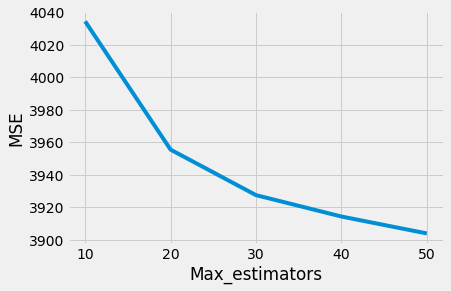

In [67]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(Max_estimators, MSE)
plt.xlabel('Max_estimators')
plt.ylabel('MSE')

### Modelo 3 - Random Forest

In [49]:
from sklearn.ensemble import RandomForestRegressor
RFreg = RandomForestRegressor()
RFreg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

### Analisis de n_estimators

In [47]:
# list of values to try for n_estimators
estimator_range = range(200, 350, 50)
list(estimator_range)

[200, 250, 300]

In [73]:
# list to store the average Accuracy for each value of n_estimators
MSE = []

for estimator in estimator_range:
    RFreg = RandomForestRegressor(bootstrap=True,criterion='mse',max_depth=None,n_estimators=estimator, 
                                  random_state=1, n_jobs=-1)
    
    # fit and predict
    RFreg.fit(X_train, y_train)
    y_pred = RFreg.predict(X_test)
    y_pred
    
    MSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))
print(MSE)

[3881.813794659865, 3879.611607113962, 3878.988026401525]


In [74]:
# show the best MSE and the corresponding n_estimators
sorted(zip(MSE, estimator_range))[::1][0]

(3878.988026401525, 300)

Text(0,0.5,'MSE')

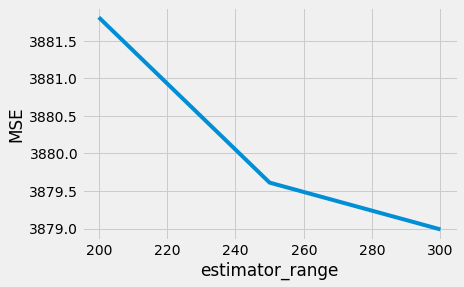

In [75]:
plt.plot(estimator_range, MSE)
plt.xlabel('estimator_range')
plt.ylabel('MSE')

In [50]:
# define features: exclude career statistics (which start with "C") and the response (Salary)
feature_cols = X_train.columns
feature_cols

Index(['Mileage', 'MR_A1R1', 'MR_A1R2', 'MR_A1R3', 'MR_A1R4', 'MR_A1R5',
       'MR_A1R6', 'MR_A1R8', 'MR_A2R1', 'MR_A2R2', 'MR_A2R3', 'MR_A2R4',
       'MR_A2R5', 'MR_A2R6', 'MR_A2R8', 'MR_A3R1', 'MR_A3R2', 'MR_A3R3',
       'MR_A3R4', 'MR_A3R5', 'MR_A3R6', 'MR_A3R8', 'MR_A4R1', 'MR_A4R2',
       'MR_A4R3', 'MR_A4R4', 'MR_A4R5', 'MR_A4R6', 'MR_A4R8', 'MR_A5R1',
       'MR_A5R2', 'MR_A5R3', 'MR_A5R4', 'MR_A5R5', 'MR_A5R6', 'MR_A5R8',
       'MR_A6R1', 'MR_A6R2', 'MR_A6R3', 'MR_A6R4', 'MR_A6R5', 'MR_A6R6',
       'MR_A6R8', 'Y_1997', 'Y_1998', 'Y_1999', 'Y_2000', 'Y_2001', 'Y_2002',
       'Y_2003', 'Y_2004', 'Y_2005', 'Y_2006', 'Y_2007', 'Y_2008', 'Y_2009',
       'Y_2010', 'Y_2011', 'Y_2012', 'Y_2013', 'Y_2014', 'Y_2015', 'Y_2016',
       'Y_2017', 'Y_2018', 'State_0', 'State_1', 'State_2', 'State_3',
       'State_4', 'State_5', 'State_6', 'Make_0', 'Make_1', 'Make_2', 'Make_3',
       'Make_4', 'Make_5', 'Make_6', 'Model_0', 'Model_1', 'Model_2',
       'Model_3', 'Model_4', 'Model_

#### Analisis Max Features

In [52]:
# list of values to try for max_features
feature_range = range(10, len(feature_cols)+1,10)
#feature_range =[6,12,18,24,30,36,42,48]
list(feature_range)

[10, 20, 30, 40, 50, 60, 70, 80, 90]

In [53]:
# list to store the average Accuracy for each value of max_features
MSE = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    RFreg = RandomForestRegressor(bootstrap=True,criterion='mse',max_features=feature, max_depth=20,n_estimators=50, 
                                  random_state=1, n_jobs=-1)
    # fit and predict
    RFreg.fit(X_train, y_train)
    y_pred = RFreg.predict(X_test)
    y_pred
    
    MSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))

In [54]:
# show the best MSE and the corresponding n_estimators
sorted(zip(MSE, feature_range))[::1][0]

(3698.4845446687405, 50)

Text(0,0.5,'MSE')

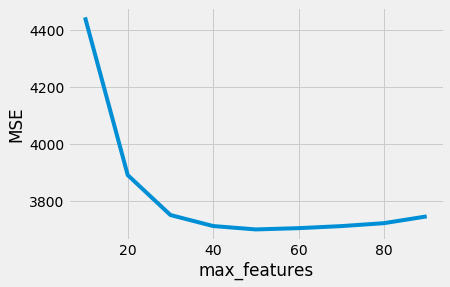

In [57]:
plt.plot(feature_range, MSE)
plt.xlabel('max_features')
plt.ylabel('MSE')

####  Analisis de max_depth

In [60]:
# list of values to try for max_depth
max_depth = range(5, 31,5)
#max_depth =[12,24,48]
list(max_depth)

[5, 10, 15, 20, 25, 30]

In [61]:
# list to store the average Accuracy for each value of max_features
MSE = []

# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for depth in max_depth:
    RFreg = RandomForestRegressor(bootstrap=True,criterion='mse',max_features=50, max_depth=depth, n_estimators=50, 
                                  random_state=1, n_jobs=-1)
    # fit and predict
    RFreg.fit(X_train, y_train)
    y_pred = RFreg.predict(X_test)
    y_pred
    
    MSE.append(np.sqrt(mean_squared_error(y_test, y_pred)))

In [62]:
# show the best MSE and the corresponding n_estimators
sorted(zip(MSE, max_depth))[::1][0]

(3698.4845446687405, 20)

Text(0,0.5,'MSE')

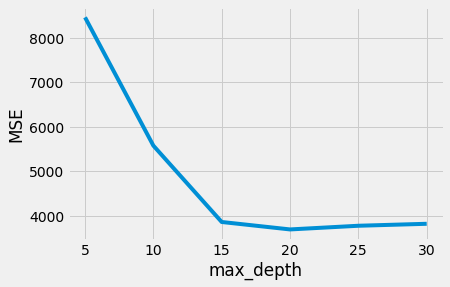

In [63]:
plt.plot(max_depth, MSE)
plt.xlabel('max_depth')
plt.ylabel('MSE')

### Fitting a Random Forest with the best parameters

In [452]:
# max_features=6 is best and n_estimators=200 is sufficiently large
RFreg = RandomForestRegressor(bootstrap=True,criterion='mse',max_features=50, max_depth=20,n_estimators=300, 
                                  random_state=1, n_jobs=-1)
# fit and predict
RFreg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=50, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=-1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [453]:
y_pred = RFreg.predict(X_test)
y_pred
    
MSE=np.sqrt(mean_squared_error(y_test, y_pred))

In [454]:
print(MSE)

3670.6358044961034


In [227]:
y_pred=pd.DataFrame(y_pred)
y_pred['Price_est']=y_pred.iloc[:,0]
y_pred=y_pred.drop(0,axis=1)
y_pred.head()

,Price_est
0,18011.472638
1,18625.655483
2,15370.675196
3,17934.905495
4,12893.692114


### Analisis de prediccion de precios

In [228]:
y_test=pd.DataFrame(y_test)
y_test['ind']=y_test.index
y_test.head()

,Price,ind
104241,18231,104241
199676,22982,199676
140199,16219,140199
132814,21995,132814
408697,17995,408697


In [231]:
Val=y_test.join(y_pred)
Val.head(10)

,Price,ind,Price_est
104241,18231,104241,14809.366125
199676,22982,199676,18619.818379
140199,16219,140199,15147.223193
132814,21995,132814,19398.150259
408697,17995,408697,NaN
163280,14900,163280,14147.772582
215758,13800,215758,33978.911555
442316,12395,442316,NaN
6940,43256,6940,26723.684554
382310,9995,382310,NaN


In [230]:
Val.shape

(250000, 3)

In [145]:
y_test1 = y_test.reset_index(drop=True)
y_test1.head()

0    18231
1    22982
2    16219
3    21995
4    17995
Name: Price, dtype: int64

In [146]:
X_test1 = X_test.reset_index(drop=True)
X_test1.head()

,Mileage,MR_A1R1,MR_A1R2,MR_A1R3,MR_A1R4,MR_A1R5,MR_A1R6,MR_A1R8,MR_A2R1,MR_A2R2,...,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10
0,30223,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1
1,12764,0,0,0,0,0,0,0,1,0,...,0,0,0,1,1,1,1,0,1,0
2,37951,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
3,80649,0,0,0,0,1,0,0,0,0,...,0,0,1,0,1,0,0,1,1,1
4,24579,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,1,1,0


In [151]:
Val=Val.join(y_pred)

In [152]:
Val.head()

,Mileage,MR_A1R1,MR_A1R2,MR_A1R3,MR_A1R4,MR_A1R5,MR_A1R6,MR_A1R8,MR_A2R1,MR_A2R2,...,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10,Price,Price_est,ind
0,30223,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,18231,18011.472638,0
1,12764,0,0,0,0,0,0,0,1,0,...,1,1,1,1,0,1,0,22982,18625.655483,1
2,37951,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,16219,15370.675196,2
3,80649,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,1,1,21995,17934.905495,3
4,24579,0,0,0,0,0,0,0,0,1,...,1,0,0,1,1,1,0,17995,12893.692114,4


In [153]:
Val.shape

(250000, 93)

## Ejecución del modelo completo y pronosticos de data_test (Identificacion del problema de tratar por separado el archivo de train y test

In [87]:
data_test['Year_s']=data_test[str('Year')]
Xd_1=pd.get_dummies(data_test['Year_s'], prefix='Y')
data2=pd.DataFrame(data_test['State'])
Xd_2 = ce.BinaryEncoder().fit_transform(data2)
data3=pd.DataFrame(data_test['Make'])
Xd_3 = ce.BinaryEncoder().fit_transform(data3)
data4=pd.DataFrame(data_test['Model'])
Xd_4 = ce.BinaryEncoder().fit_transform(data4)
Xd_test =pd.concat([data_test['Mileage'],Xd_1,Xd_2,Xd_3,Xd_4],axis=1)
Xd_test.head(10)

,Mileage,Y_1997,Y_1998,Y_1999,Y_2000,Y_2001,Y_2002,Y_2003,Y_2004,Y_2005,...,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10
ID,,,,,,,,,,,,,,,,,,,,,
0,23388,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,45061,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,101033,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
3,13590,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,118916,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
5,82447,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
6,82939,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,1
7,122878,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,35091,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [88]:
Xd_test.shape

(250000, 48)

In [89]:
X.shape

(500000, 48)

In [90]:
y.shape

(500000,)

In [91]:
# fit and predict
RFreg.fit(X, y)
y_pred = RFreg.predict(X_test)
y_pred=pd.DataFrame(y_pred)
y_pred.head(5)

,0
0,18183.029935
1,20159.919506
2,15818.427816
3,20657.102207
4,13219.443571


In [92]:
y_pred.shape

(250000, 1)

In [93]:
y_pred['Price_est']=y_pred.iloc[:,0]
y_pred.head(5)

,0,Price_est
0,18183.029935,18183.029935
1,20159.919506,20159.919506
2,15818.427816,15818.427816
3,20657.102207,20657.102207
4,13219.443571,13219.443571


In [94]:
y_pred=y_pred['Price_est']

In [95]:
y_pred.head(5)

0    18183.029935
1    20159.919506
2    15818.427816
3    20657.102207
4    13219.443571
Name: Price_est, dtype: float64

In [96]:
data_resp =pd.concat([data_test,y_pred],axis=1)
data_resp.head(10)

,Year,Mileage,State,Make,Model,Year_s,Price_est
ID,,,,,,,
0,2015,23388,OH,Ford,EscapeFWD,2015,18183.029935
1,2014,45061,PA,Ford,EscapeSE,2014,20159.919506
2,2007,101033,WI,Toyota,Camry4dr,2007,15818.427816
3,2015,13590,HI,Jeep,Wrangler,2015,20657.102207
4,2009,118916,CO,Dodge,Charger4dr,2009,13219.443571
5,2006,82447,OH,Chevrolet,Impala4dr,2006,15222.102947
6,2008,82939,FL,Honda,Accord,2008,13641.418736
7,2010,122878,TN,GMC,Yukon2WD,2010,15026.254756
8,2015,35091,OH,Honda,CivicEX,2015,45206.090839


In [97]:
data_resp['Mileage_c'] = 'Na'
data_resp.loc[(data_resp['Mileage'] > 0)      & (data_resp['Mileage'] <= 20000 ), 'Mileage_c'] = 'R1'
data_resp.loc[(data_resp['Mileage'] > 20000)  & (data_resp['Mileage'] <= 40000 ), 'Mileage_c'] = 'R2'
data_resp.loc[(data_resp['Mileage'] > 40000)  & (data_resp['Mileage'] <= 60000 ), 'Mileage_c'] = 'R3'
data_resp.loc[(data_resp['Mileage'] > 60000)  & (data_resp['Mileage'] <= 80000 ), 'Mileage_c'] = 'R4'
data_resp.loc[(data_resp['Mileage'] > 80000)  & (data_resp['Mileage'] <= 100000), 'Mileage_c'] = 'R5'
data_resp.loc[(data_resp['Mileage'] > 100000) & (data_resp['Mileage'] <= 120000), 'Mileage_c'] = 'R6'
data_resp.loc[(data_resp['Mileage'] > 120000) & (data_resp['Mileage'] <= 140000), 'Mileage_c'] = 'R7'
data_resp.loc[(data_resp['Mileage'] > 120000), 'Mileage_c'] = 'R8'
data_resp.head(5)

,Year,Mileage,State,Make,Model,Year_s,Price_est,Mileage_c
ID,,,,,,,,
0,2015,23388,OH,Ford,EscapeFWD,2015,18183.029935,R2
1,2014,45061,PA,Ford,EscapeSE,2014,20159.919506,R3
2,2007,101033,WI,Toyota,Camry4dr,2007,15818.427816,R6
3,2015,13590,HI,Jeep,Wrangler,2015,20657.102207,R1
4,2009,118916,CO,Dodge,Charger4dr,2009,13219.443571,R6


In [101]:
Price_test=data_resp.groupby(['Year','Model','Mileage_c'])['Price_est'].mean()
Price_test.head(10)

Year  Model           Mileage_c
1997  3               R5           16559.320327
                      R8           34277.202349
      4RunnerLimited  R8           13718.477511
      Altima4dr       R8           16243.108819
      Avalon4dr       R3           17796.588728
      Boxster2dr      R6           16213.445005
                      R8           23509.048865
      Camaro2dr       R1           15755.385143
                      R3           10776.618370
                      R5           27519.129188
Name: Price_est, dtype: float64

# API

# Instrucciones para ejecutar

## Ingrese a la siguiente dirección:

http://3.17.72.118:8888

## El API recibe los datos exactos en cada campo. Es decir, para cada campo se deben seguir las siguientes instrucciones:

* Year: Cuatro dígitos y entre 1997 y 2018
* State: Dos caracteres en mayúsculas
* Make: Primer letra en mayúscula y el nombre debe ser el mismo que está registrado en la base
* Model: Primer letra en mayúscula y el nombre debe ser el mismo que está registrado en la base

Puede consultar la base completa para revisar los nombres de los estados, fabricantes y los modelos en el siguiente enlace:
https://github.com/julianfbaquero/PracticalMachineLearningClass/blob/master/P1/Variables-datos.pdf

## Ejemplos

* A continuación se muestran dos ejemplos de la ejecución de la app

#### Ejemplo 1:

![EX12.png](attachment:EX12.png)
![EX13.png](attachment:EX13.png)

#### Ejemplo 2:
![EX2.png](attachment:EX2.png)
![EX22.png](attachment:EX22.png)
![EX23.png](attachment:EX23.png)

### En los dos ejemplos se muestra cómo la app arroja un resultado lógico luego de ingresar los datos solicitados